In [1]:
%matplotlib Qt

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import csv
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import Quadrangle

In [38]:
data = pd.read_csv("2mass.csv", usecols=["RAJ2000", "DEJ2000", "Jmag", "Hmag", "Kmag", "Qflg"])
mask = (data['Qflg'] == 'AAA') & (data['Jmag'] > 8) & (data['Jmag'] < 15)
data = data[mask]
data.dropna(inplace=True)
data['J-H'] = data['Jmag'] - data['Hmag']
coords = SkyCoord(ra=data["RAJ2000"], dec=data["DEJ2000"], frame='icrs', unit=u.degree)

plt.hist(data['Jmag'], bins=50, cumulative=True, density=True)
data.plot(kind="hist", bins=20, logy=True, y="Jmag")

<Axes: ylabel='Frequency'>

In [14]:
def create_wcs(center: SkyCoord, cdelt=1*u.arcmin, size=1*u.deg):
    pixsize = int((size.to(cdelt.unit)/cdelt).value)
    transform=ax.get_transform('fk5')
    wcs = WCS(naxis=2)
    wcs.wcs.cdelt = [-cdelt.value, cdelt.value]
    wcs.wcs.cunit = [cdelt.unit, cdelt.unit]
    wcs.wcs.ctype = ["RA", "DEC"]
    wcs.wcs.crpix = [pixsize/2., pixsize/2.]
    wcs.wcs.crval = [center.ra.to(cdelt.unit).value, center.dec.to(cdelt.unit).value]
    wcs.pixel_shape = [pixsize, pixsize]
    return(wcs)

In [15]:
center = SkyCoord('03:29:11.28 +31:18:36.00', unit=(u.hourangle, u.deg))
# center = SkyCoord(ra_grid.mean(), dec_grid.mean(), unit=(u.arcsec, u.arcsec))
cdelt = 1 * u.arcmin
wcs = create_wcs(center, cdelt, size=2.5*u.deg)

In [23]:
fig, ax = plt.subplots(subplot_kw=dict(projection=wcs))
sc = ax.scatter(coords.ra, coords.dec, c=data['Jmag']-data['Hmag'], s=20, cmap='RdBu_r')
ax.set_facecolor("grey")
fig.colorbar(sc)

In [42]:
fig, ax = plt.subplots(figsize=(8,6), subplot_kw=dict(projection=wcs))
image = np.zeros(wcs.pixel_shape)
ax.imshow(image)

x, y = wcs.world_to_pixel(coords)
sc = ax.scatter(x, y, c=data['Jmag']-data['Hmag'], s=20, cmap='RdBu_r')# color by whatever you like

# define rectangle: lower-left corner (xmin, ymin) and width/height
xmin, ymin = 51.7*u.deg, 30.5*u.deg
width, height = 0.3*u.deg, 0.3*u.deg
rect = Quadrangle((xmin, ymin), width, height, edgecolor='red', facecolor='none', linewidth=1, transform=ax.get_transform('world'))
ax.add_patch(rect)

# boolean mask to get points inside
mask = (coords.ra >= xmin) & (coords.ra <= xmin + width) & (coords.dec >= ymin) & (coords.dec <= ymin + height)
selected_data = data[mask]          # dataframe of the selected points
print("Selected points:", len(selected_coords))

# highlight selected points on the plot
ax.scatter(x[mask], y[mask], facecolors='none', edgecolors='red', s=25)
ax.set_xlabel('RA'); ax.set_ylabel('Dec')
ax.set_facecolor("grey")
fig.colorbar(sc)
# plt.gca().invert_xaxis()
plt.show()
# now selected_df contains the rows that fell inside the rectangle

Selected points: 97


In [44]:
mean_jh = np.mean(selected_data["J-H"].values)
std_jh = np.std(selected_data["J-H"].values)
print(std_jh)

0.1507684626977567


In [7]:
corr_j = data["J-H"] - mean_bv

def red_law(R_v, bv):
    a_v = R_v * bv
    return a_v

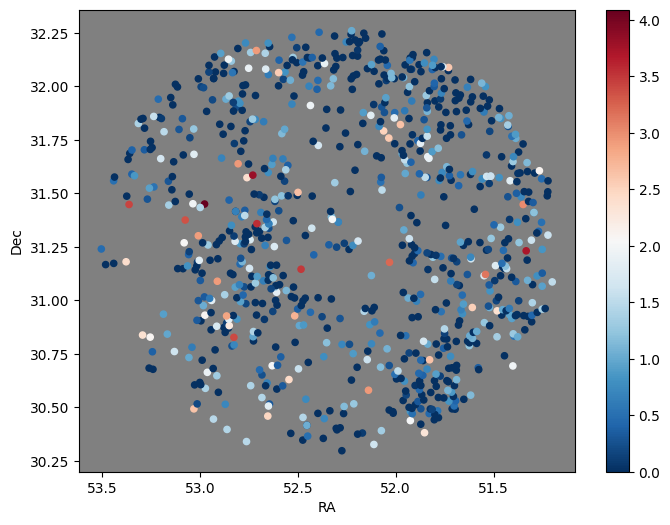

In [9]:
R_v = 3.1
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(x, y, s=20, cmap='RdBu_r', c=red_law(R_v, corr_bv), vmin=0)  # color by whatever you like


ax.set_xlabel('RA'); ax.set_ylabel('Dec')
fig.colorbar(sc)
ax.set_facecolor("grey")
plt.gca().invert_xaxis()
plt.show()